In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load your dataset (replace the path with your actual file)
df = pd.read_csv('crypto_data.csv')

# Check the first few rows of the df
df.head()

# Step 2: Calculate Log Changes (Log-Returns) for Forecasting
df['Log_Close'] = np.log(df['Close'])

# Calculate the log change (percentage change in the log price)
df['Log_Change'] = df['Log_Close'].diff()  # This will be the target variable

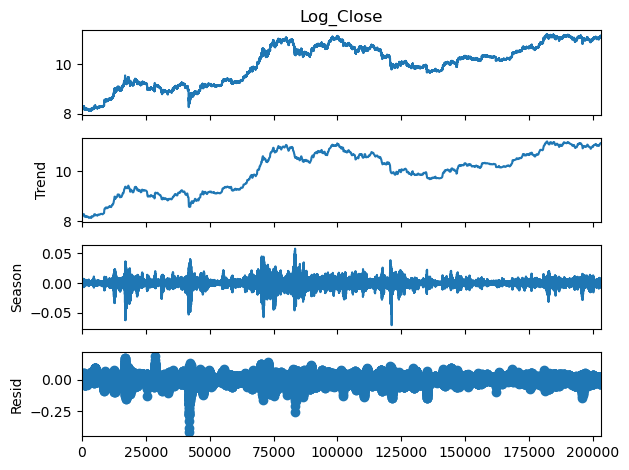

In [13]:
from statsmodels.tsa.seasonal import STL

# Step 3: STL Decomposition
seasonal_period = 96  # 15-minute intervals per day (96 intervals in 24 hours)
stl = STL(df['Log_Close'], period=seasonal_period, robust=True)
result = stl.fit()

# Get the decomposed components
df['STL_Trend'] = result.trend
df['STL_Seasonal'] = result.seasonal
df['STL_Residual'] = result.resid

# Plot the decomposed components
result.plot()
plt.show()


In [14]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,Log_Change,STL_Trend,STL_Seasonal,STL_Residual
0,2019-01-01 00:00:00,3701.23,3703.72,3689.88,3697.31,190.974095,8.215361,NaN,8.223030,0.008693,-0.016362
1,2019-01-01 00:15:00,3697.91,3698.75,3690.56,3694.20,131.742721,8.214519,-0.000842,8.223058,0.003783,-0.012322
2,2019-01-01 00:30:00,3693.96,3705.00,3693.00,3702.39,171.877714,8.216734,0.002215,8.223087,0.002429,-0.008782
3,2019-01-01 00:45:00,3702.05,3713.00,3695.02,3700.31,191.772890,8.216172,-0.000562,8.223116,0.001880,-0.008824
4,2019-01-01 01:00:00,3700.20,3702.73,3691.22,3701.03,139.872706,8.216366,0.000195,8.223145,0.001995,-0.008774


In [15]:
# Drop NaN values that may appear due to the diff() operation
df = df.dropna()
# Let's split based on a timestamp, for example:
train_start = '2019-01-02'
train_end = '2024-01-01'
valid_start = '2024-01-02'
valid_end = '2024-04-01'
predict_start = '2024-04-02'
predict_end = '2024-10-20'

# Convert timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df = df.rename(columns={'Timestamp':})
# Split the df into training, validation, and prediction sets
train_df = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
valid_df = df[(df['Timestamp'] >= valid_start) & (df['Timestamp'] <= valid_end)]
predict_df = df[(df['Timestamp'] >= predict_start) & (df['Timestamp'] <= predict_end)]

# Now train_df, valid_df, predict_df are the respective datasets

In [16]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,Log_Change,STL_Trend,STL_Seasonal,STL_Residual
1,2019-01-01 00:15:00,3697.91,3698.75,3690.56,3694.20,131.742721,8.214519,-0.000842,8.223058,0.003783,-0.012322
2,2019-01-01 00:30:00,3693.96,3705.00,3693.00,3702.39,171.877714,8.216734,0.002215,8.223087,0.002429,-0.008782
3,2019-01-01 00:45:00,3702.05,3713.00,3695.02,3700.31,191.772890,8.216172,-0.000562,8.223116,0.001880,-0.008824
4,2019-01-01 01:00:00,3700.20,3702.73,3691.22,3701.03,139.872706,8.216366,0.000195,8.223145,0.001995,-0.008774
5,2019-01-01 01:15:00,3702.39,3702.39,3695.46,3699.25,135.318759,8.215885,-0.000481,8.223175,0.001497,-0.008786


In [17]:
# Adding features to the data (using the code you already wrote)
lags = [10, 20, 50]
def add_features(df, lags):
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log(np.array(df['Close']) /  
                                             np.roll(np.append(np.convolve(np.array(df['Close']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
        df[f'log_return_{lag}'] = np.log(np.array(df['Close']) / np.roll(np.array(df['Close']), lag))

    for lag in lags:
        df[f'mean_close/mean_{lag}'] = np.mean(df.iloc[:, df.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:, df.columns.str.startswith(f'log_return_{lag}')], axis=1)
        
    for lag in lags:
        df[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = np.array(df[f'log_close/mean_{lag}']) - np.array(df[f'mean_close/mean_{lag}'])
        df[f'log_return_{lag}-mean_log_returns_{lag}'] = np.array(df[f'log_return_{lag}']) - np.array(df[f'mean_log_returns_{lag}'])
    return df

# Apply feature engineering to the entire dataset
train_df = add_features(train_df, lags)
valid_df = add_features(valid_df, lags)
predict_df = add_features(predict_df, lags)


C:\Users\kyo\AppData\Local\Temp\ipykernel_16220\3241662076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_close/mean_{lag}'] = np.log(np.array(df['Close']) /
C:\Users\kyo\AppData\Local\Temp\ipykernel_16220\3241662076.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'log_return_{lag}'] = np.log(np.array(df['Close']) / np.roll(np.array(df['Close']), lag))
C:\Users\kyo\AppData\Local\Temp\ipykernel_16220\3241662076.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [21]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Set up features and target variable
X_train = train_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] +
                   [f'log_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}' for lag in lags] +
                   [f'mean_close/mean_{lag}' for lag in lags] +
                   [f'mean_log_returns_{lag}' for lag in lags] +
                   [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags]]

y_train = train_df['Log_Change']  # Or use classification targets if applicable

# Train a LightGBM model
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, lgb_train, 100)

# Now we have our trained model


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 174931, number of used features: 20
[LightGBM] [Info] Start training from score 0.000014


In [22]:
X_predict = predict_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] +
                       [f'log_close/mean_{lag}' for lag in lags] +
                       [f'log_return_{lag}' for lag in lags] +
                       [f'mean_close/mean_{lag}' for lag in lags] +
                       [f'mean_log_returns_{lag}' for lag in lags] +
                       [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] +
                       [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags]]
df_pred = predict_df.copy()
df_pred['Predict'] = lgb_model.predict(X_predict)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions on the validation set
X_valid = valid_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] +
                   [f'log_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}' for lag in lags] +
                   [f'mean_close/mean_{lag}' for lag in lags] +
                   [f'mean_log_returns_{lag}' for lag in lags] +
                   [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags]]
y_valid = valid_df['Log_Change']  # Replace with your target column for validation

y_pred = lgb_model.predict(X_valid)

# RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
# MAE
mae = mean_absolute_error(y_valid, y_pred)
# R2 Score
r2 = r2_score(y_valid, y_pred)
# Correlation Coefficient
correlation = np.corrcoef(y_valid, y_pred)[0, 1]

# Display metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Correlation Coefficient: {correlation:.4f}")


RMSE: 0.0025
MAE: 0.0017
R^2 Score: 0.3440
Correlation Coefficient: 0.5870


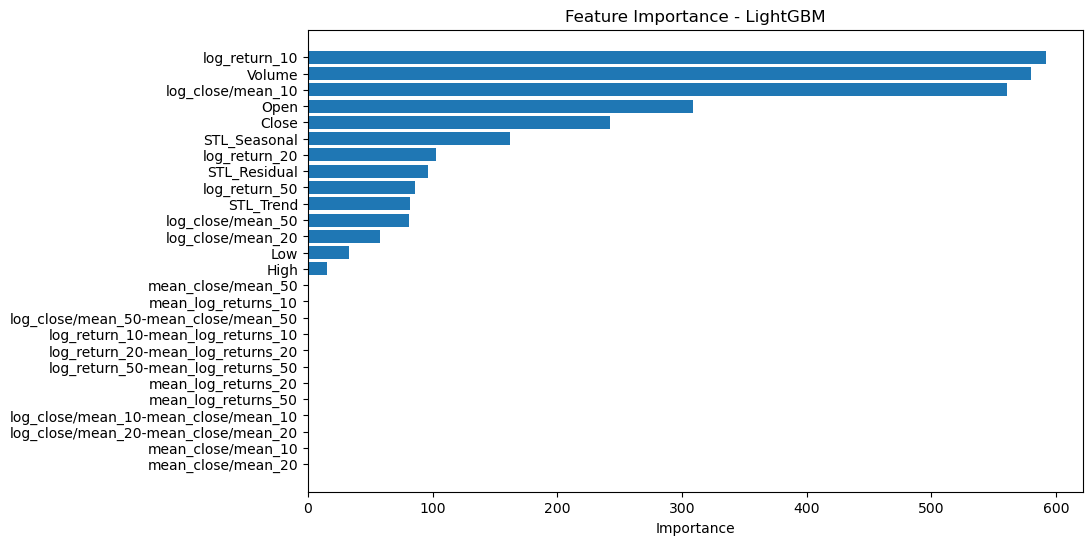

In [30]:
import matplotlib.pyplot as plt

# Plot feature importance using Matplotlib
importance = lgb_model.feature_importance(importance_type='split')
features = X_valid.columns

# Sort features by importance
sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance - LightGBM')
plt.show()

100%|██████████| 19297/19297 [00:02<00:00, 9093.26it/s]


Total Profits: -100.00%
Max Drawdown: 100.00%
Trade Count: 2126
Win Ratio: 0.01
Average Profit per Trade: -0.0470%


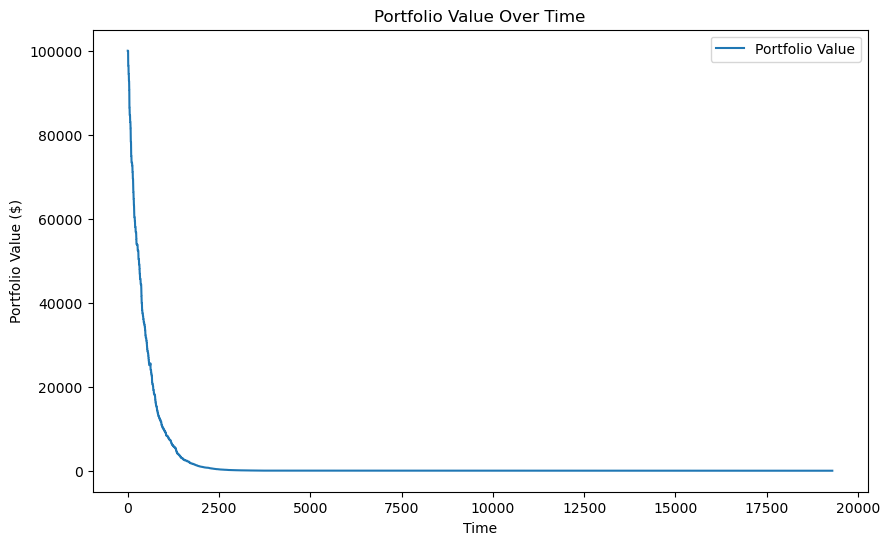

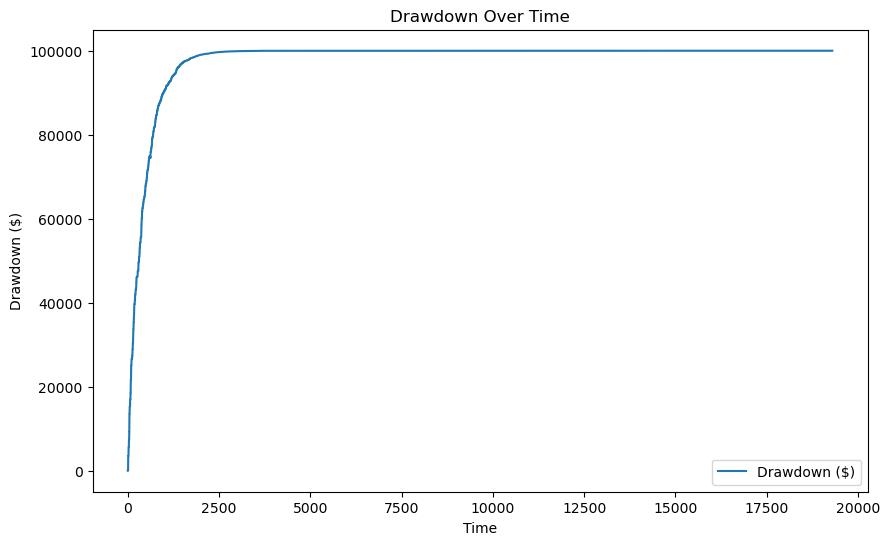

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize backtesting parameters
initial_balance = 100000
trading_balance_ratio = 1
threshold_values = [1e-07]
total_profits = []
drawdowns = []
trade_counts = []
win_ratios = []
average_profits = []

df_pred['position'] = 0  # Add a column for positions

# Backtesting loop
for threshold in threshold_values:
    current_balance = initial_balance
    current_position = 0
    entry_price = 0
    trades = []
    portfolio_values = [initial_balance]
    win_trades = 0
    loss_trades = 0
    peak_balance = initial_balance
    max_drawdown = 0

    for i in tqdm(range(len(df_pred))):
        # Entry condition: open a position if no position is held and the prediction exceeds the threshold
        if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
            current_position = 1
            entry_price = df_pred.iloc[i]['Close']
            entry_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = 1

        # Exit condition: close the position if the prediction is less than 0
        elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
            current_position = 0
            exit_price = df_pred.iloc[i]['Close']
            exit_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = -1
            
            # Adjusted trade return calculation with slippage
            trade_return = (exit_price * 0.99 - entry_price * 1.01) / (entry_price * 1.01)
            trade_profit = trade_return * min(99000, current_balance)
            current_balance += trade_profit
            
            # Calculate trade duration in minutes
            trade_duration = (exit_time - entry_time).total_seconds() / 60  # Time in minutes
            trades.append((entry_price, entry_time, exit_price, exit_time, trade_return, trade_duration, current_balance))
            
            # Track wins and losses
            if trade_profit > 0:
                win_trades += 1
            else:
                loss_trades += 1

        # Track portfolio value
        portfolio_values.append(current_balance)
        peak_balance = max(peak_balance, current_balance)
        drawdown = (peak_balance - current_balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Calculate key metrics
    total_profit = (current_balance - initial_balance) / initial_balance * 100
    average_profit_per_trade = total_profit / len(trades) if trades else 0
    win_ratio = win_trades / len(trades) if trades else 0

    total_profits.append(total_profit)
    drawdowns.append(max_drawdown)
    trade_counts.append(len(trades))
    win_ratios.append(win_ratio)
    average_profits.append(average_profit_per_trade)

# Displaying final performance summary
print(f'Total Profits: {total_profits[-1]:.2f}%')
print(f'Max Drawdown: {drawdowns[-1]:.2f}%')
print(f'Trade Count: {trade_counts[-1]}')
print(f'Win Ratio: {win_ratios[-1]:.2f}')
print(f'Average Profit per Trade: {average_profits[-1]:.4f}%')

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

# Plot drawdown over time
plt.figure(figsize=(10, 6))
drawdown_values = [peak_balance - value for value in portfolio_values]
plt.plot(drawdown_values, label='Drawdown ($)')
plt.xlabel('Time')
plt.ylabel('Drawdown ($)')
plt.title('Drawdown Over Time')
plt.legend()
plt.show()


In [25]:
print("Tổng phần trăm lãi:", total_profits[0])
print("Max Drawdown:", drawdowns[0])
print("Số lượng giao dịch", trade_counts[0])
print("Tỉ lệ giao dịch có lãi:", win_ratios[0])
print("Phần trăm lãi trung bình 1 giao dịch:", average_profits[0])

Tổng phần trăm lãi: -100.0
Max Drawdown: 100.0
Số lượng giao dịch 2126
Tỉ lệ giao dịch có lãi: 0.011288805268109126
Phần trăm lãi trung bình 1 giao dịch: -0.047036688617121354
